In [1]:
#### 4.1 这版 是把@科大财经本地化版，特点是 根据交易周期change_n而制定的change_day，间隔买入，（而不是像ctq的根据给出信号，每日买入）20250416
from FH_QM_DC.MQplatform import * ##M,D
import duckdb as db
import ast
import pandas as pd
import numpy as np
import talib as ta
import os
import re
import traceback
import bottleneck as bn
from scipy.stats import rankdata

# from FH_QM_DC.f3_derived_feature_extractor_20250325 import column

# 设置显示选项，保留 6 位小数
pd.set_option('display.float_format', lambda x: '%.6f' % x)
from tqdm import tqdm
import logging
# 配置日志记录器
logging.basicConfig(level=logging.INFO)
# 获取日志记录器实例
logger = logging.getLogger(__name__)
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [4]:
# 1.过滤出上市天数大于60天的股票
# 2.a股过滤，只选择上证、深证、创业板，过滤st、*st、停牌的股票。
# 3.过滤条件：5日平均价穿过10日平均价
# 4.筛选5日收益排名前5的票作为持仓
# 5.股票持仓2天，即第一天开盘买，第二天收盘卖（日频）
# 引用开发包M,G

#定义参数
par = {
    # 定义所使用的因子，这里使用5日、10日的收盘价均线的相关因子
    'features': [
        # 5日收益率因子
        'factor1=return_2',
        # 'factor1=return_1',
        'factor2=close_0/close_2',
        'factor3=close_0/close_3',
        # 这里表达式表示 昨日的MA5<MA10,今日的MA5>MA10，满足条件则为1，否则为0，用来做筛选
        # 'buy_cond_1=where((shift(mean(close_0,5),1)<shift(mean(close_0,10),1))&(mean(close_0,5)>mean(close_0,10)),1,0)',
        'buy_cond_1=where(high_0/close_0,1,0)',
        # 筛选条件2，选取上市天数>60天的股票
        'buy_cond_2=where(list_days_0>60,1,0)'
    ],
    # 因子计算需要向前抽取天数
    'shift_days': 30,
    # 过滤条件
    'stock_filter_cond': 'buy_cond_1==1&buy_cond_2==1',
    # 交易日期
    'trade_date_start': '20250111',
    'trade_date_end': '20250328',
}
#交易日期模块 trade_date_block = M.trade_date(par['trade_date_start'], par['trade_date_end']) ### 时段限定
sedts = M.input_date(par['trade_date_start'], par['trade_date_end'])[:2] ## debugged: 因为input_date函数有三个输出值，因子这里要用[:2] #;print(len(trade_days))
print(sedts)

(20250113, 20250328)


In [5]:
#### 股票or板块类型限定，筛选时空df
mconn,mtable,sdf_filtered = M.sel_instrument_time_and_space(input_date=sedts, shift_days=par['shift_days'], ret_days=0,feature_type='stock',stock_board_cond = [1,2,3], stock_st_cond = 0, output_df=True,is_use_cache=False)
# mconn,mtable,sdf_filtered = M.sel_instrument_time_and_space(input_date=sedts, shift_days=20, ret_days=2,feature_type='ths',stock_board_cond =None, stock_st_cond = None, output_df=True,is_use_cache=False)
sdf_filtered.head(3)

INFO:FH_QM_DC.MQplatform:(20241129, 20250328)


查询后的,存到内存中的table df shape (348367, 115)
Loaded 348367 records into general_memory_stock_table.


,instrument,date,open,high,low,close,up_limit,down_limit,adjust_factor_0,close_0,...,hf_trend_str7_0,hf_trend_str8_0,hf_trend_str9_0,hf_trend_str10_0,hf_trend_str11_0,hf_trend_str12_0,hf_trend_str13_0,hf_volume_ratio_stage_0,hf_ratio_up_cum_avg_price_0,hf_ratio_close_cum_avg_price_0
0,000001.SZ,20241129.000000,11.370000,11.460000,11.340000,11.380000,12.470000,10.210000,127.784000,1454.183000,...,-0.141000,-0.909000,0.073000,-0.077000,0.000000,0.085000,0.000000,98.533000,0.498000,-0.023000
1,000002.SZ,20241129.000000,8.430000,8.730000,8.420000,8.600000,9.330000,7.630000,181.704000,1562.654000,...,0.000000,0.000000,0.134000,-0.114000,0.045000,0.158000,-0.098000,36.037000,0.755000,-0.009000
2,000004.SZ,20241129.000000,18.000000,18.330000,17.860000,18.150000,19.680000,16.100000,4.064000,73.762000,...,0.198000,-0.909000,0.017000,-0.046000,0.015000,0.138000,-0.058000,31.424000,0.664000,0.040000


In [6]:
# 因子模块 # features_block = M.input_features(None, par['features'])
all_feature_list = M.input_features(None,par['features'],is_rank='normal',is_use_cache=False)[0]##[:1] ##
all_feature_list

['factor1=return_2',
 'factor2=close_0/close_2',
 'factor3=close_0/close_3',
 'buy_cond_1=where(high_0/close_0,1,0)',
 'buy_cond_2=where(list_days_0>60,1,0)']

In [7]:
#基础特征因子抽取 #### 2.4 M.general_feature_extractor
gdf = M.general_feature_extractor(input_df=sdf_filtered,input_feature_list=all_feature_list, feature_type='stock',is_use_cache=False)
gdf

INFO:FH_QM_DC.MQplatform:basic feature instrument end is not int num
INFO:FH_QM_DC.MQplatform:basic feature date end is not int num
INFO:FH_QM_DC.MQplatform:basic feature open end is not int num
INFO:FH_QM_DC.MQplatform:basic feature high end is not int num
INFO:FH_QM_DC.MQplatform:basic feature low end is not int num
INFO:FH_QM_DC.MQplatform:basic feature close end is not int num
INFO:FH_QM_DC.MQplatform:basic feature up_limit end is not int num
INFO:FH_QM_DC.MQplatform:basic feature down_limit end is not int num


junior_feature_list: ['return_', 'daily_return_', 'rank_return_', 'ta_ad_', 'ta_adx_', 'ta_aroon_down_', 'ta_aroon_up_', 'ta_aroonosc_', 'ta_atr_', 'ta_bbands_lowerband_', 'ta_bbands_middleband_', 'ta_bbands_upperband_', 'ta_cci_', 'ta_macd_macd_', 'ta_macd_macdhist', 'ta_macd_macdsignal_', 'ta_mfi_', 'ta_mom_', 'ta_obv_', 'ta_rsi_', 'ta_sar_', 'ta_stoch_slowd_', 'ta_stoch_slowk_', 'ta_trix_', 'ta_willr_', 'ta_ema_', 'ta_sma_', 'ta_wma_', 'ta_ewm_']
sel_basic_cols: ['turn_', 'return_', 'close_', 'high_', 'list_days_']
junior_feature: return_
junior_basic_feature: close_0


,date,instrument,high_0,turn_0,list_days_0,close_0
0,20241129.000000,000001.SZ,1464.406000,0.530000,12295.000000,1454.183000
1,20241129.000000,000002.SZ,1586.276000,1.534000,12359.000000,1562.654000
2,20241129.000000,000004.SZ,74.493000,6.703000,12374.000000,73.762000
3,20241129.000000,000006.SZ,361.634000,6.499000,11905.000000,353.289000
4,20241129.000000,000007.SZ,61.550000,2.766000,11919.000000,60.142000
...,...,...,...,...,...,...
348362,20250328.000000,301628.SZ,90.280000,5.060000,149.000000,88.420000
348363,20250328.000000,301629.SZ,172.210000,38.180000,5.000000,157.380000
348364,20250328.000000,301631.SZ,124.940000,7.683000,127.000000,120.500000
348365,20250328.000000,301633.SZ,86.320000,4.037000,142.000000,83.810000


In [8]:
### 衍生特征抽取
ddf = get_derived_feature_extractor(input_df=gdf,
                                input_feature_list=all_feature_list,
                                feature_type='stock',
                                input_date=sedts,
                                remove_extra_columns=False, #True, #
                                is_use_cache=False
                                    )
ddf

fe: factor1=return_2
factor1 return_2
this_junior_feature: return_2 this_basic_feature: return_0 num: 2
因子 factor1 计算完成
(348367, 8)
fe: factor2=close_0/close_2
factor2 close_0/close_2
node.id: close_0
this_junior_feature: close_2 this_basic_feature: close_0 num: 2
else: df,this_basic_feature:,num: close_0 2
因子 factor2 计算完成
(348367, 11)
fe: factor3=close_0/close_3
factor3 close_0/close_3
node.id: close_0
this_junior_feature: close_3 this_basic_feature: close_0 num: 3
else: df,this_basic_feature:,num: close_0 3
因子 factor3 计算完成
(348367, 13)
fe: buy_cond_1=where(high_0/close_0,1,0)
buy_cond_1 where(high_0/close_0,1,0)
node.id: high_0
node.id: close_0
[0        1.007030
1        1.015117
2        1.009910
3        1.023621
4        1.023411
           ...   
348362   1.021036
348363   1.094231
348364   1.036846
348365   1.029949
348366   1.023714
Name: _temp_1, Length: 348367, dtype: float64, 1, 0]
因子 buy_cond_1 计算完成
(348367, 16)
fe: buy_cond_2=where(list_days_0>60,1,0)
buy_cond_2 where(lis

,date,instrument,high_0,turn_0,list_days_0,close_0,return_2,factor1,close_2,factor2,_temp_0,close_3,factor3,buy_cond_1,_temp_1,_temp_2,buy_cond_2
132154,20250113.000000,000001.SZ,1649.645000,0.482000,12340.000000,1640.855000,0.973913,0.973913,1670.156000,0.982456,True,1684.807000,0.973913,1.000000,True,1,1.000000
132155,20250113.000000,000002.SZ,1184.935000,0.938000,12404.000000,1183.184000,0.971264,0.971264,1216.439000,0.972662,True,1218.190000,0.971264,1.000000,True,1,1.000000
132156,20250113.000000,000004.SZ,58.948000,5.542000,12419.000000,58.759000,0.930600,0.930600,62.482000,0.940415,True,63.141000,0.930600,1.000000,True,1,1.000000
132157,20250113.000000,000006.SZ,484.313000,1.717000,11950.000000,480.688000,0.952586,0.952586,500.264000,0.960869,True,504.614000,0.952586,1.000000,True,1,1.000000
132158,20250113.000000,000007.SZ,68.285000,0.879000,11964.000000,68.185000,0.984138,0.984138,71.284000,0.956526,True,69.284000,0.984138,1.000000,True,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348362,20250328.000000,301628.SZ,90.280000,5.060000,149.000000,88.420000,0.982444,0.982444,89.300000,0.990146,True,90.000000,0.982444,1.000000,True,1,1.000000
348363,20250328.000000,301629.SZ,172.210000,38.180000,5.000000,157.380000,0.993937,0.993937,158.500000,0.992934,False,158.340000,0.993937,1.000000,False,0,0.000000
348364,20250328.000000,301631.SZ,124.940000,7.683000,127.000000,120.500000,0.937014,0.937014,127.900000,0.942142,True,128.600000,0.937014,1.000000,True,1,1.000000
348365,20250328.000000,301633.SZ,86.320000,4.037000,142.000000,83.810000,0.979547,0.979547,85.450000,0.980807,True,85.560000,0.979547,1.000000,True,1,1.000000


In [9]:
## # 数据过滤 filter_block = M.filter(d_features_block.get_data(), par['stock_filter_cond'])
print(par['stock_filter_cond'])
filtered_df = ddf.query(par['stock_filter_cond']) ## 直接query 过滤 'buy_cond_1==1&buy_cond_2==1'
filtered_df


buy_cond_1==1&buy_cond_2==1


,date,instrument,high_0,turn_0,list_days_0,close_0,return_2,factor1,close_2,factor2,_temp_0,close_3,factor3,buy_cond_1,_temp_1,_temp_2,buy_cond_2
132154,20250113.000000,000001.SZ,1649.645000,0.482000,12340.000000,1640.855000,0.973913,0.973913,1670.156000,0.982456,True,1684.807000,0.973913,1.000000,True,1,1.000000
132155,20250113.000000,000002.SZ,1184.935000,0.938000,12404.000000,1183.184000,0.971264,0.971264,1216.439000,0.972662,True,1218.190000,0.971264,1.000000,True,1,1.000000
132156,20250113.000000,000004.SZ,58.948000,5.542000,12419.000000,58.759000,0.930600,0.930600,62.482000,0.940415,True,63.141000,0.930600,1.000000,True,1,1.000000
132157,20250113.000000,000006.SZ,484.313000,1.717000,11950.000000,480.688000,0.952586,0.952586,500.264000,0.960869,True,504.614000,0.952586,1.000000,True,1,1.000000
132158,20250113.000000,000007.SZ,68.285000,0.879000,11964.000000,68.185000,0.984138,0.984138,71.284000,0.956526,True,69.284000,0.984138,1.000000,True,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348361,20250328.000000,301626.SZ,87.650000,3.033000,156.000000,84.770000,0.966480,0.966480,87.270000,0.971353,True,87.710000,0.966480,1.000000,True,1,1.000000
348362,20250328.000000,301628.SZ,90.280000,5.060000,149.000000,88.420000,0.982444,0.982444,89.300000,0.990146,True,90.000000,0.982444,1.000000,True,1,1.000000
348364,20250328.000000,301631.SZ,124.940000,7.683000,127.000000,120.500000,0.937014,0.937014,127.900000,0.942142,True,128.600000,0.937014,1.000000,True,1,1.000000
348365,20250328.000000,301633.SZ,86.320000,4.037000,142.000000,83.810000,0.979547,0.979547,85.450000,0.980807,True,85.560000,0.979547,1.000000,True,1,1.000000


In [10]:
btdf=filtered_df.pivot_table(index='date',columns='instrument',values='return_2')##.unstack()
btdf.head(2)

instrument,000001.SZ,000002.SZ,000004.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,000012.SZ,...,605507.SH,605555.SH,605566.SH,605567.SH,605577.SH,605580.SH,605588.SH,605589.SH,605598.SH,605599.SH
date,,,,,,,,,,,,,,,,,,,,,
20250113.000000,0.973913,0.971264,0.930600,0.952586,0.984138,0.992422,0.976825,1.033776,0.972798,0.974311,...,0.980616,1.015868,1.017845,0.956920,0.960444,0.950418,0.994849,1.076959,0.838519,0.939037
20250114.000000,0.998246,0.994245,0.995471,0.994203,0.985972,1.041508,1.000000,1.060808,0.994073,1.008016,...,1.030180,1.045029,0.979214,0.997717,1.014928,1.019423,1.015279,1.062053,0.846617,0.989681


In [11]:
def get_buy_list(df,top_type = 'rank',rank_n = 100,quantile_q = 0.8):
    """
    :param df: 因子值 -> dataframe/unstack
    :param top_tpye: 选择买入队列方式，从['rank','quantile']选择一种方式 ->
    :param rank_n: 值最大的前n只的股票 -> int
    :param quantile_q: 值最大的前n分位数的股票 -> float
    :return df: 买入队列 -> dataframe/unstack
    """
    if top_type == 'rank':
        df = df.rank(axis  = 1,ascending=False) <= rank_n
    elif top_type == 'quantile':
        df = df.sub(df.quantile(quantile_q,axis = 1),axis = 0) > 0
    else:
        print("select one from ['rank','quantile']")

    df = df.astype(int)
    df = df.replace(0,np.nan).dropna(how = 'all',axis = 1)

    return df
buy_list=get_buy_list(btdf,top_type='rank',rank_n=5,quantile_q=0.8)
buy_list.head(3)

instrument,000409.SZ,000421.SZ,000665.SZ,000785.SZ,000856.SZ,000882.SZ,000953.SZ,002058.SZ,002086.SZ,002105.SZ,...,603700.SH,603716.SH,603928.SH,603949.SH,603956.SH,605066.SH,605100.SH,605277.SH,605303.SH,605398.SH
date,,,,,,,,,,,,,,,,,,,,,
20250113.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20250114.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20250115.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
btdf_weight=buy_list.div(buy_list.sum(axis = 1),axis = 0)
btdf_weight = btdf_weight.shift(1).dropna(how='all') ### 这里才出现了
btdf_weight.to_csv('btdf_weight_20250420.csv')
btdf_weight.head(3)

instrument,000409.SZ,000421.SZ,000665.SZ,000785.SZ,000856.SZ,000882.SZ,000953.SZ,002058.SZ,002086.SZ,002105.SZ,...,603700.SH,603716.SH,603928.SH,603949.SH,603956.SH,605066.SH,605100.SH,605277.SH,605303.SH,605398.SH
date,,,,,,,,,,,,,,,,,,,,,
20250114.000000,NaN,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20250115.000000,NaN,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20250116.000000,NaN,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# ### 得到 各股票一手所能买的股票数量
# stock_round_lot=pd.Series(dict([(s,200) if s.startswith('300') or s.startswith('68') else (s,100) for s in btdf_weight.columns.tolist()]))
# stock_round_lot

In [14]:
# #### 获得 各股票各对应日期 open_0 值
# #### 使用对应时间、标的和基本因子抽取，可以获得这些股票的open_0 宽表数据
# def get_bar(df):
#     """
#     :param df: 买入队列 -> dataframe/unstack
#     :param benchmark: 基准指数 -> str
#     :return ret: 基准的逐日收益 -> dataframe
#     """
#     start_date = df.index.min()
#     end_date = df.index.max()
#     stock_list = df.columns.tolist()
#     start_date,end_date,len(stock_list)
#     input_date = M.input_date(str(int(start_date)),str(int(end_date)))
#     _,_,sel_stocks_df=M.sel_instrument_time_and_space(input_date, shift_days=0, ret_days=0, feature_type='stock', stock_board_cond=[1,2,3],
#                                           stock_st_cond=0, output_df=True, is_use_cache=False)
#     price_open=sel_stocks_df[sel_stocks_df.instrument.isin(stock_list)].pivot_table(index='date',columns='instrument',values='open')
#
#     return price_open
#
# price_open=get_bar(btdf_weight)
# price_open

### # 不含涨跌停 without slippage
# name = 's1bt'
# rf = 0.03
# benchmark_index = '000852.SH' ##'000985.XSHG'
# benchmark_type = 'mcw'
### based on fh_qm_dc data:
def get_benchmark(df,benchmark,benchmark_type = 'mcw'):
    """
    :param df: 买入队列 -> dataframe/unstack
    :param benchmark: 基准指数 -> str
    :return ret: 基准的逐日收益 -> dataframe
    """
    start_date = df.index.min()
    end_date = df.index.max()
    if benchmark_type == 'mcw':
        # price_open = get_price([benchmark],start_date,end_date,fields=['open']).open.unstack('order_book_id')
        index_daily=pd.read_csv(r"D:\CTQuant_client\CTQuant_DATA\stock_a\base\index_daily.csv")
        index_daily = index_daily[(index_daily['date']>=start_date)&(index_daily['date']<=end_date)]
        price_open = index_daily[index_daily.index_code==benchmark][['date','index_open_0']].rename(columns={'index_open_0':benchmark}).set_index('date')
    else:
        index_fix = INDEX_FIX(start_date,end_date,benchmark)
        stock_list = index_fix.columns.tolist()
        price_open = get_price(stock_list,start_date,end_date,fields=['open']).open.unstack('order_book_id')
        price_open = price_open.pct_change().mask(~index_fix).mean(axis = 1)
        price_open = (1 + price_open).cumprod().to_frame(benchmark)

    return price_open
# index_open=get_benchmark(btdf_weight,benchmark='000852.SH',benchmark_type = 'mcw')
# index_open



def get_performance_analysis(account_result, name = ' ',rf = 0.03,benchmark_index = '000852.SH',benchmark_type = 'mcw'):
    import statsmodels.api as sm

    # 加入基准
    performance = pd.concat([account_result['total_account_asset'].to_frame('strategy'),
                             get_benchmark(account_result,benchmark_index,benchmark_type)],axis = 1)
    performance.index = pd.to_datetime([str(int(d)) for d in performance.index])
    performance_net = performance.pct_change().dropna(how = 'all')                                # 清算至当日开盘
    performance_cumnet = (1 + performance_net).cumprod()
    performance_cumnet['alpha'] = performance_cumnet['strategy']/performance_cumnet[benchmark_index]
    performance_cumnet = performance_cumnet.fillna(1)

    # 指标计算
    performance_pct = performance_cumnet.pct_change().dropna()

    # 策略收益
    strategy_name,benchmark_name,alpha_name = performance_cumnet.columns.tolist()
    Strategy_Final_Return = performance_cumnet[strategy_name].iloc[-1] - 1

    # 策略年化收益
    Strategy_Annualized_Return_EAR = (1 + Strategy_Final_Return) ** (252/len(performance_cumnet)) - 1

    # 基准收益
    Benchmark_Final_Return = performance_cumnet[benchmark_name].iloc[-1] - 1

    # 基准年化收益
    Benchmark_Annualized_Return_EAR = (1 + Benchmark_Final_Return) ** (252/len(performance_cumnet)) - 1

    # alpha
    ols_result = sm.OLS(performance_pct[strategy_name] * 252 - rf, sm.add_constant(performance_pct[benchmark_name] * 252 - rf)).fit()
    Alpha = ols_result.params[0]

    # beta
    Beta = ols_result.params[1]

    # beta_2 = np.cov(performance_pct[strategy_name],performance_pct[benchmark_name])[0,1]/performance_pct[benchmark_name].var()
    # 波动率
    Strategy_Volatility = performance_pct[strategy_name].std() * np.sqrt(252)

    # 夏普
    Strategy_Sharpe = (Strategy_Annualized_Return_EAR - rf)/Strategy_Volatility

    # 下行波动率
    strategy_ret = performance_pct[strategy_name]
    Strategy_Down_Volatility = strategy_ret[strategy_ret < 0].std() * np.sqrt(252)

    # sortino
    Sortino = (Strategy_Annualized_Return_EAR - rf)/Strategy_Down_Volatility

    # 跟踪误差
    Tracking_Error = (performance_pct[strategy_name] - performance_pct[benchmark_name]).std() * np.sqrt(252)

    # 信息比率
    Information_Ratio = (Strategy_Annualized_Return_EAR - Benchmark_Annualized_Return_EAR)/Tracking_Error

    # 最大回测
    i = np.argmax((np.maximum.accumulate(performance_cumnet[strategy_name])
                    - performance_cumnet[strategy_name])
                    /np.maximum.accumulate(performance_cumnet[strategy_name]))
    j = np.argmax(performance_cumnet[strategy_name][:i])
    Max_Drawdown = (1-performance_cumnet[strategy_name][i]/performance_cumnet[strategy_name][j])

    # 卡玛比率
    Calmar = (Strategy_Annualized_Return_EAR)/Max_Drawdown

    # 超额收益
    Alpha_Final_Return = performance_cumnet[alpha_name].iloc[-1] - 1

    # 超额年化收益
    Alpha_Annualized_Return_EAR = (1 + Alpha_Final_Return) ** (252/len(performance_cumnet)) - 1

    # 超额波动率
    Alpha_Volatility = performance_pct[alpha_name].std() * np.sqrt(252)

    # 超额夏普
    Alpha_Sharpe = (Alpha_Annualized_Return_EAR - rf)/Alpha_Volatility

    # 超额最大回撤
    i = np.argmax((np.maximum.accumulate(performance_cumnet[alpha_name])
                    - performance_cumnet[alpha_name])
                    /np.maximum.accumulate(performance_cumnet[alpha_name]))
    j = np.argmax(performance_cumnet[alpha_name][:i])
    Alpha_Max_Drawdown = (1-performance_cumnet[alpha_name][i]/performance_cumnet[alpha_name][j])

    # 胜率
    performance_pct['win'] = performance_pct[alpha_name] > 0
    Win_Ratio = performance_pct['win'].value_counts().loc[True] / len(performance_pct)

    # 盈亏比
    profit_lose = performance_pct.groupby('win')[alpha_name].mean()
    # Profit_Lose_Ratio = ABS(profit_lose[True]/profit_lose[False])
    Profit_Lose_Ratio = abs(profit_lose[True]/profit_lose[False])


    result_en = {
        'Strategy_Final_Return':round(Strategy_Final_Return,4),
        'Strategy_Annualized_Return_EAR': round(Strategy_Annualized_Return_EAR,4),
        'Benchmark_Final_Return':round(Benchmark_Final_Return,4),
        'Benchmark_Annualized_Return_EAR': round(Benchmark_Annualized_Return_EAR,4),
        'Alpha':round(Alpha,4),
        'Beta':round(Beta,4),
        'Volatility':round(Strategy_Volatility,4),
        'Sharpe':round(Strategy_Sharpe,4),
        'Down_Volatility':round(Strategy_Down_Volatility,4),
        'Sortino':round(Sortino,4),
        'Tracking_Error':round(Tracking_Error,4),
        'Information_Ratio':round(Information_Ratio,4),
        'Max_Drawdown':round(Max_Drawdown,4),
        'Calmar': round(Calmar,4),
        'Alpha_Final_Return':round(Alpha_Final_Return,4),
        'Alpha_Annualized_Return_EAR': round(Alpha_Annualized_Return_EAR,4),
        'Alpha_Volatility':round(Alpha_Volatility,4),
        'Alpha_Sharpe':round(Alpha_Sharpe,4),
        'Alpha_Max_Drawdown':round(Alpha_Max_Drawdown,4),
        'Win_Ratio':round(Win_Ratio,4),
        'Profit_Lose_Ratio':round(Profit_Lose_Ratio,4)
    }

    result_cn = {
        '策略累计收益':round(Strategy_Final_Return,4),
        '策略年化收益': round(Strategy_Annualized_Return_EAR,4),
        '基准累计收益':round(Benchmark_Final_Return,4),
        '基准年化收益': round(Benchmark_Annualized_Return_EAR,4),
        '阿尔法':round(Alpha,4),
        '贝塔':round(Beta,4),
        '波动率':round(Strategy_Volatility,4),
        '夏普比率':round(Strategy_Sharpe,4),
        '下行波动率':round(Strategy_Down_Volatility,4),
        '索提诺比率':round(Sortino,4),
        '跟踪误差':round(Tracking_Error,4),
        '信息比率':round(Information_Ratio,4),
        '最大回撤':round(Max_Drawdown,4),
        '卡玛比率': round(Calmar,4),
        '超额累计收益':round(Alpha_Final_Return,4),
        '超额年化收益': round(Alpha_Annualized_Return_EAR,4),
        '超额波动率':round(Alpha_Volatility,4),
        '超额夏普':round(Alpha_Sharpe,4),
        '超额最大回撤':round(Alpha_Max_Drawdown,4),
        '胜率':round(Win_Ratio,4),
        '盈亏比':round(Profit_Lose_Ratio,4)

    }


    # 回测图绘制
    import matplotlib.pyplot as plt

    x = performance_cumnet.index
    y1 = performance_cumnet['strategy']
    y2 = performance_cumnet[benchmark_index]
    y3 = performance_cumnet['alpha']


    fig, ax = plt.subplots()

    ax.plot(x, y1, label='strategy',color = 'darkred')
    ax.plot(x, y2, label=benchmark_index)
    ax.plot(x, y3, label='alpha')
    plt.title(name)

    # 调整子图的布局，留出空间给表格
    plt.subplots_adjust(right=1.4, top=1.1)
    # 创建一个额外的空白子图
    # 添加表格
    cell_text =  [['指标','数值']] + [list(result_cn.items())][0]
    table = ax.table(cellText=cell_text, loc='right')

    # 调整表格的大小
    #table.scale(0.7, 0.7)

    # 设置单元格的属性
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # 对第一行进行处理
            cell.set_text_props(fontsize=10, ha='center', va='center')  # 居中对齐
        elif j == 0:  # 对第一列进行处理
            cell.set_text_props(fontsize=10, ha='left', va='center')  # 左对齐
        else:
            cell.set_text_props(fontsize=10, ha='right', va='center')  # 右对齐

    # 设置行高
    for i in range(len(cell_text)):
        table._cells[(i, 0)].set_height(0.0454)
        table._cells[(i, 1)].set_height(0.0453)
    table.auto_set_column_width([0, 1])
    table.auto_set_font_size(False)

    # 显示图例
    ax.legend()
    plt.show()

    return performance_cumnet,result_cn

def get_buy_list(df,top_type = 'rank',rank_n = 100,quantile_q = 0.8):
    """
    :param df: 因子值 -> dataframe/unstack
    :param top_tpye: 选择买入队列方式，从['rank','quantile']选择一种方式 ->
    :param rank_n: 值最大的前n只的股票 -> int
    :param quantile_q: 值最大的前n分位数的股票 -> float
    :return df: 买入队列 -> dataframe/unstack
    """
    if top_type == 'rank':
        df = df.rank(axis  = 1,ascending=False) <= rank_n
    elif top_type == 'quantile':
        df = df.sub(df.quantile(quantile_q,axis = 1),axis = 0) > 0
    else:
        print("select one from ['rank','quantile']")

    df = df.astype(int)
    df = df.replace(0,np.nan).dropna(how = 'all',axis = 1)

    return df



In [15]:
# start_date = btdf_weight.index.min()
# end_date = btdf_weight.index.max()
# stock_list = btdf_weight.columns.tolist()
# start_date,end_date,len(stock_list)
# input_date = M.input_date(str(int(start_date)),str(int(end_date)))
# ### bug:这里时间段截取有问题：
# _,_,sel_stocks_df=M.sel_instrument_time_and_space(input_date, shift_days=1, ret_days=0, feature_type='stock', stock_board_cond=[1,2,3],
#                                       stock_st_cond=0, output_df=True, is_use_cache=False)
# price_df=sel_stocks_df[sel_stocks_df.instrument.isin(stock_list)][['date','instrument','close','open','down_limit','up_limit']]##.pivot_table(index='date',columns='instrument',values='open')
# price_df

In [16]:
# price_open = price_df.pivot_table(index='date',columns='instrument',values='open')
# price_open

In [24]:
df_weight=btdf_weight.copy()
change_n = 1 #2
change_day = sorted(set(df_weight.index.tolist()[::change_n] + [df_weight.index[-1]]))
change_day
### 这里可见，ctq的买卖逻辑是每天都买，第二天卖出，是每天买入的间隔一天，第二天尾盘卖出。

[20250114.0,
 20250115.0,
 20250116.0,
 20250117.0,
 20250120.0,
 20250121.0,
 20250122.0,
 20250123.0,
 20250124.0,
 20250127.0,
 20250205.0,
 20250206.0,
 20250207.0,
 20250210.0,
 20250211.0,
 20250212.0,
 20250213.0,
 20250214.0,
 20250217.0,
 20250218.0,
 20250219.0,
 20250220.0,
 20250221.0,
 20250224.0,
 20250225.0,
 20250226.0,
 20250227.0,
 20250228.0,
 20250303.0,
 20250304.0,
 20250305.0,
 20250306.0,
 20250307.0,
 20250310.0,
 20250311.0,
 20250312.0,
 20250313.0,
 20250314.0,
 20250317.0,
 20250318.0,
 20250319.0,
 20250320.0,
 20250321.0,
 20250324.0,
 20250325.0,
 20250326.0,
 20250327.0,
 20250328.0]

In [17]:
# 不含涨跌停 without slippage
df_weight = btdf_weight.copy()
change_n = 1#2 ##20
cash = 10000 * 1000
tax = 0.0005
other_tax = 0.0001
commission = 0.0002
min_fee = 5
cash_interest_yield = 0.02
signal = True  ##False
def backtest(df_weight, change_n = 2, cash = 10000 * 1000, tax = 0.0005, other_tax = 0.0001, commission = 0.0002, min_fee = 5, cash_interest_yield = 0.02,signal = False):
    '''
    change_n = 20: 调仓天数
    cash：资金
    tax=0.0005: 印花税
    other_tax: 0.0001其他杂费
    commission=0.0002： 券商佣金 万二
    min_fee=5: 最低交易费用
    cash_interest_yield = 0.02现金利率
    signal = False 是否打印买卖明细表
    '''

    # 基础参数
    inital_cash = cash                                # 起始资金
    stock_holding_num_hist = 0                        # 初始化持仓
    buy_cost = other_tax + commission                 # 买入交易成本
    sell_cost = tax + other_tax + commission          # 卖出交易成本
    cash_interest_daily = (1 + cash_interest_yield) ** (1/252) - 1          # 现金账户利息(日)
    ### 三个账户：总账户，股票账户，现金账户
    account = pd.DataFrame(index = df_weight.index,columns=['total_account_asset','holding_market_cap','cash_account'])          # 账户信息存储
    # price_open = get_bar(df_weight)          # 获取开盘价格数据
    ### 得到 各股票一手所能买的股票数量
    stock_round_lot = pd.Series(dict([(s,200) if s.startswith('300') or s.startswith('68') else (s,100) for s in btdf_weight.columns.tolist()]))
    ### 每一天的调仓情况
    change_day = sorted(set(df_weight.index.tolist()[::change_n] + [df_weight.index[-1]]))                                        # 调仓日期
    cannot_sellable_stock_list_temp = []
    #### 取 down_limit 数据，形成同日，weight_df 所选当日股票 buy_out_stock_list_temp，所对应的 ['open','limit_down'] 两列数据
    # price_open_limit = get_price(buy_out_stock_list_temp,start_date,start_date,fields=['open','limit_down']).droplevel(1)
    # df = btdf_weight.copy()
    start_date = btdf_weight.index.min()
    end_date = btdf_weight.index.max()
    stock_list = btdf_weight.columns.tolist()
    # start_date,end_date,len(stock_list)
    input_date = M.input_date(str(int(start_date)),str(int(end_date)))
    ### bug:这里时间段截取有问题：
    _,_,sel_stocks_df=M.sel_instrument_time_and_space(input_date, shift_days=1, ret_days=0, feature_type='stock', stock_board_cond=[1,2,3],
                                          stock_st_cond=0, output_df=True, is_use_cache=False)
    price_df = sel_stocks_df[sel_stocks_df.instrument.isin(stock_list)][['date','instrument','close','open','down_limit','up_limit']]##.pivot_table(index='date',columns='instrument',values='open')
    ### also from above price_df
    price_open = price_df.pivot_table(index='date',columns='instrument',values='open') ##
    ### 逐行test，看数据输入输出和各部分作用！
    # 不含涨跌停

    # 滚动计算
    for i in tqdm(range(0,len(change_day)-1)): ## 遍历每个调仓日
        start_date = change_day[i] ## 在开始日买入
        end_date = change_day[i+1] ## 在结束日卖出



        # 获取给定权重
        df_weight_temp = df_weight.loc[start_date].dropna() ## 得到初始的买入权重
        stock_list_temp = df_weight_temp.index.tolist() ## 得到买入股票list
        # 计算个股持股数量 = 向下取整(给定权重 * 可用资金 // 最小买入股数) * 最小买入股数
        stock_holding_num = ((df_weight_temp
                            * cash ##现有资金
                            / (price_open.loc[start_date,stock_list_temp] * (1 + sell_cost)) # 预留交易费用
                            // stock_round_lot.loc[stock_list_temp]) ## 每个股票一手对应多少股数，取整！
                            * stock_round_lot.loc[stock_list_temp])

        # 仓位变动
        stock_holding_num_change = stock_holding_num.sub(stock_holding_num_hist,fill_value = 0) ## 现有持仓
        stock_holding_num_change = stock_holding_num_change.replace(0,np.nan).dropna() ## 如果是0，用空置代替
        if signal: ## 如果显示没日持仓记录
            for k,v in stock_holding_num_change.to_dict().items():
                if v < 0:
                    print(start_date,'卖出',k,int(v),'股')
                else:
                    print(start_date,'买入',k,int(v),'股')


        # 获取期间价格
        price_open_temp = price_open.loc[start_date:end_date]
        # 计算交易成本 (可设置万一免五)
        def calc_fee(x,min_fee):
            if x < 0: ## x 是 卖出 或买入的钱数，x负值是卖出的意思
                fee_temp = -1 * x * sell_cost    ### 这里 -1 的作用是 负负得正                                                                                   # 印花税 + 过户费等 + 佣金
            else: ## x正值是买入的意思
                fee_temp = x * buy_cost                                                                                             # 过户费等 + 佣金
            # 最低交易成本限制
            if fee_temp > min_fee:
                return fee_temp
            else:
                return min_fee

        ### 总交易成本：
        transaction_costs = ((price_open_temp.loc[start_date]
                            * stock_holding_num_change)).apply(lambda x: calc_fee(x,min_fee)).sum()
        # 计算期间市值 （交易手续费在现金账户计提）
        holding_market_cap = (price_open_temp * stock_holding_num).sum(axis =1)
        cash_account = cash - transaction_costs - holding_market_cap.loc[start_date] ### 剩余资金
        ### cash_account 累成后的结果
        cash_account = pd.Series([cash_account*((1 + cash_interest_daily)**(i+1)) for i in range(0,len(holding_market_cap))],
                                index = holding_market_cap.index)
        total_account_asset = holding_market_cap + cash_account ### 总账户 = 股票账户 + 资金账户

        # 将当前持仓存入
        stock_holding_num_hist = stock_holding_num
        # 下一期期初可用资金
        cash = total_account_asset.loc[end_date]

        account.loc[start_date:end_date,'total_account_asset'] = round(total_account_asset,2)
        account.loc[start_date:end_date,'holding_market_cap'] = round(holding_market_cap,2)
        account.loc[start_date:end_date,'cash_account'] = round(cash_account,2)

    ### 加入初始行：
    account.loc[account.index.min()] = [inital_cash,0,inital_cash]
    account = account.sort_index()

    return account
account_result = backtest(df_weight, change_n = 1, cash = 500000, tax = 0.0005, other_tax = 0.0001, commission = 0.0002, min_fee = 5, cash_interest_yield = 0.02,signal = True)
account_result

INFO:FH_QM_DC.MQplatform:(20250113, 20250328)


查询后的,存到内存中的table df shape (216213, 115)
Loaded 216213 records into general_memory_stock_table.


100%|██████████| 47/47 [00:00<00:00, 506.48it/s]

20250114.0 买入 000421.SZ 12700 股
20250114.0 买入 300344.SZ 15400 股
20250114.0 买入 300953.SZ 1000 股
20250114.0 买入 301413.SZ 1300 股
20250114.0 买入 301511.SZ 6200 股
20250115.0 卖出 000421.SZ -100 股
20250115.0 卖出 300344.SZ -1600 股
20250115.0 卖出 300953.SZ -1000 股
20250115.0 买入 301511.SZ 600 股
20250116.0 买入 000421.SZ 1800 股
20250116.0 买入 300071.SZ 16800 股
20250116.0 买入 300242.SZ 19400 股
20250116.0 卖出 300344.SZ -800 股
20250116.0 买入 300792.SZ 2800 股
20250116.0 卖出 301413.SZ -1300 股
20250116.0 卖出 301511.SZ -6800 股
20250117.0 卖出 000421.SZ -14400 股
20250117.0 买入 300071.SZ 600 股
20250117.0 买入 300166.SZ 9800 股
20250117.0 卖出 300242.SZ -200 股
20250117.0 卖出 300344.SZ -400 股
20250117.0 卖出 300792.SZ -200 股
20250120.0 买入 002691.SZ 13100 股
20250120.0 买入 002917.SZ 4900 股
20250120.0 卖出 300071.SZ -17400 股
20250120.0 卖出 300166.SZ -9800 股
20250120.0 卖出 300242.SZ -19200 股
20250120.0 卖出 300344.SZ -12600 股
20250120.0 卖出 300792.SZ -2600 股
20250120.0 买入 600539.SH 10600 股
20250120.0 买入 600714.SH 7500 股
20250120.0 买入 603177.

,total_account_asset,holding_market_cap,cash_account
date,,,
20250114.000000,500000,0,500000
20250115.000000,542959.800000,426021.000000,116938.800000
20250116.000000,519042.400000,511768.000000,7274.400000
20250117.000000,520384.660000,510572.000000,9812.660000
20250120.000000,494669.170000,492067.000000,2602.170000
20250121.000000,453993.050000,450822.000000,3171.050000
20250122.000000,430774.900000,424756.000000,6018.900000
20250123.000000,455277.740000,445606.000000,9671.740000
20250124.000000,399133.360000,396387.000000,2746.360000


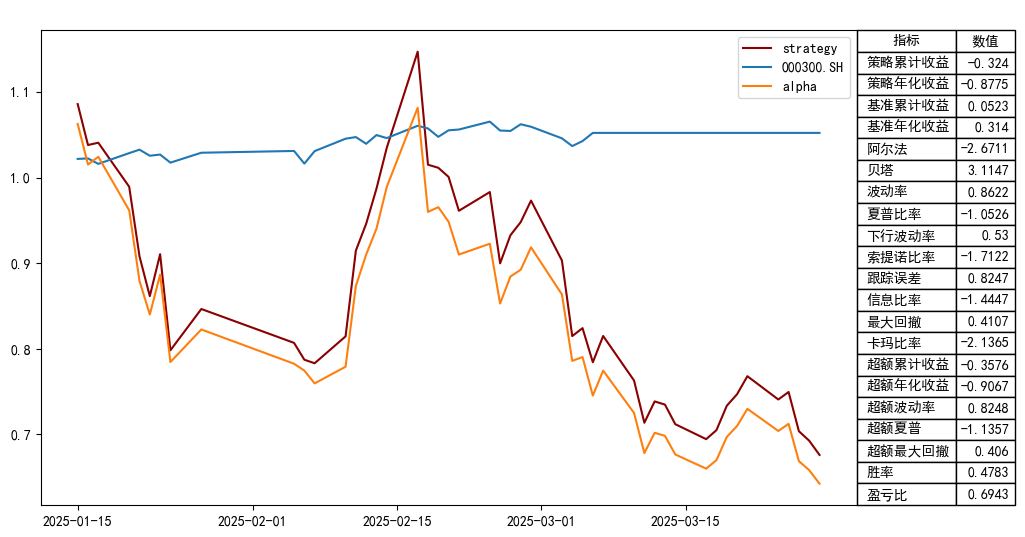

,strategy,000300.SH,alpha
2025-01-15,1.085920,1.021853,1.062697
2025-01-16,1.038085,1.022432,1.015310
2025-01-17,1.040769,1.016043,1.024336
2025-01-20,0.989338,1.028630,0.961802
2025-01-21,0.907986,1.032667,0.879263
2025-01-22,0.861550,1.025583,0.840058
2025-01-23,0.910555,1.026951,0.886659
2025-01-24,0.798267,1.017512,0.784528
2025-01-27,0.846511,1.029073,0.822595
2025-02-05,0.806939,1.031150,0.782562


In [18]:
#### 无涨跌停 without slippage
performance_cumnet,result_cn  = get_performance_analysis(account_result, name = ' ',rf = 0.03,benchmark_index = '000300.SH',benchmark_type = 'mcw')
performance_cumnet#,result_cn

In [28]:
# 不含涨跌停 with slippage
df_weight = btdf_weight.copy()
change_n = 1#2 ##20
cash = 10000 * 1000
tax = 0.0005
other_tax = 0.0001
commission = 0.0002
min_fee = 5
cash_interest_yield = 0.02
signal = True  ##False
slippage = 0.00246 ### 参考jq.com中系统默认的滑点是 PriceRelatedSlippage(0.00246)
def backtest(df_weight, change_n = 2, cash = 10000 * 1000, slippage = 0.00246 ,tax = 0.0005, other_tax = 0.0001, commission = 0.0002, min_fee = 5, cash_interest_yield = 0.02,signal = False):
    '''
    change_n = 20: 调仓天数
    cash：资金
    tax=0.0005: 印花税
    other_tax: 0.0001其他杂费
    commission=0.0002： 券商佣金 万二
    min_fee=5: 最低交易费用
    cash_interest_yield = 0.02现金利率
    signal = False 是否打印买卖明细表
    '''

    # 基础参数
    inital_cash = cash                                # 起始资金
    stock_holding_num_hist = 0                        # 初始化持仓
    buy_cost = other_tax + commission                 # 买入交易成本
    sell_cost = tax + other_tax + commission          # 卖出交易成本
    cash_interest_daily = (1 + cash_interest_yield) ** (1/252) - 1          # 现金账户利息(日)
    ### 三个账户：总账户，股票账户，现金账户
    account = pd.DataFrame(index = df_weight.index,columns=['total_account_asset','holding_market_cap','cash_account'])          # 账户信息存储
    # price_open = get_bar(df_weight)          # 获取开盘价格数据
    ### 得到 各股票一手所能买的股票数量
    stock_round_lot = pd.Series(dict([(s,200) if s.startswith('300') or s.startswith('68') else (s,100) for s in btdf_weight.columns.tolist()]))
    ### 每一天的调仓情况
    change_day = sorted(set(df_weight.index.tolist()[::change_n] + [df_weight.index[-1]]))                                        # 调仓日期
    cannot_sellable_stock_list_temp = []
    #### 取 down_limit 数据，形成同日，weight_df 所选当日股票 buy_out_stock_list_temp，所对应的 ['open','limit_down'] 两列数据
    # price_open_limit = get_price(buy_out_stock_list_temp,start_date,start_date,fields=['open','limit_down']).droplevel(1)
    # df = btdf_weight.copy()
    start_date = btdf_weight.index.min()
    end_date = btdf_weight.index.max()
    stock_list = btdf_weight.columns.tolist()
    # start_date,end_date,len(stock_list)
    input_date = M.input_date(str(int(start_date)),str(int(end_date)))
    ### bug:这里时间段截取有问题：
    _,_,sel_stocks_df=M.sel_instrument_time_and_space(input_date, shift_days=1, ret_days=0, feature_type='stock', stock_board_cond=[1,2,3],
                                          stock_st_cond=0, output_df=True, is_use_cache=False)
    price_df = sel_stocks_df[sel_stocks_df.instrument.isin(stock_list)][['date','instrument','close','open','down_limit','up_limit']]##.pivot_table(index='date',columns='instrument',values='open')
    ### also from above price_df
    price_open = price_df.pivot_table(index='date',columns='instrument',values='open') ##
    ### 逐行test，看数据输入输出和各部分作用！
    # 不含涨跌停

    # 滚动计算
    for i in tqdm(range(0,len(change_day)-1)): ## 遍历每个调仓日
        start_date = change_day[i] ## 在开始日买入
        end_date = change_day[i+1] ## 在结束日卖出



        # 获取给定权重
        df_weight_temp = df_weight.loc[start_date].dropna() ## 得到初始的买入权重
        stock_list_temp = df_weight_temp.index.tolist() ## 得到买入股票list
        # 计算个股持股数量 = 向下取整(给定权重 * 可用资金 // 最小买入股数) * 最小买入股数
        stock_holding_num = ((df_weight_temp
                            * cash ##现有资金
                            / (price_open.loc[start_date,stock_list_temp] *(1+slippage/2) *(1 + sell_cost)) # 预留交易费用 ### 添加slippage
                            // stock_round_lot.loc[stock_list_temp]) ## 每个股票一手对应多少股数，取整！
                            * stock_round_lot.loc[stock_list_temp])

        # 仓位变动
        stock_holding_num_change = stock_holding_num.sub(stock_holding_num_hist,fill_value = 0) ## 现有持仓
        stock_holding_num_change = stock_holding_num_change.replace(0,np.nan).dropna() ## 如果是0，用空置代替
        if signal: ## 如果显示没日持仓记录
            for k,v in stock_holding_num_change.to_dict().items():
                if v < 0:
                    print(start_date,'卖出',k,int(v),'股')
                else:
                    print(start_date,'买入',k,int(v),'股')


        # 获取期间价格
        price_open_temp = price_open.loc[start_date:end_date] ## 此处不该加，因为买入时，有滑点的买入价会高些，卖出时有滑点的价会低些* (1+slippage/2) ### 添加slippage

        # 计算交易成本 (可设置万一免五)
        def calc_fee(x,min_fee):
            if x < 0: ## x 是 卖出 或买入的钱数，x负值是卖出的意思
                ### 这里加入了卖出时滑点比例 right！
                fee_temp = -1 * x *(1-slippage/2) * sell_cost    ### 这里 -1 的作用是 负负得正 # 印花税 + 过户费等 + 佣金
            else: ## x正值是买入的意思
                ### 这里考虑了买入时 滑点比例 right！
                fee_temp = x *(1+slippage/2) * buy_cost        # 过户费等 + 佣金
            # 最低交易成本限制
            if fee_temp > min_fee:
                return fee_temp
            else:
                return min_fee

        ### 总交易成本：
        transaction_costs = ((price_open_temp.loc[start_date]
                            * stock_holding_num_change)).apply(lambda x: calc_fee(x,min_fee)).sum()
        # 计算期间市值 （交易手续费在现金账户计提） ### 注：因为买卖都有滑点，同样数量，但是因为差价，买卖之后的持有市值相当与没有滑点的 1*slippage/2*2
        holding_market_cap = (price_open_temp *(1+slippage) * stock_holding_num).sum(axis =1) ### 这里涉及到 买入价，因此也要考虑滑点引起的价格变化
        cash_account = cash - transaction_costs - holding_market_cap.loc[start_date] ### 剩余资金
        ### cash_account 累成后的结果
        cash_account = pd.Series([cash_account*((1 + cash_interest_daily)**(i+1)) for i in range(0,len(holding_market_cap))],
                                index = holding_market_cap.index)
        total_account_asset = holding_market_cap + cash_account ### 总账户 = 股票账户 + 资金账户

        # 将当前持仓存入
        stock_holding_num_hist = stock_holding_num
        # 下一期期初可用资金
        cash = total_account_asset.loc[end_date]

        account.loc[start_date:end_date,'total_account_asset'] = round(total_account_asset,2)
        account.loc[start_date:end_date,'holding_market_cap'] = round(holding_market_cap,2)
        account.loc[start_date:end_date,'cash_account'] = round(cash_account,2)

    ### 加入初始行：
    account.loc[account.index.min()] = [inital_cash,0,inital_cash]
    account = account.sort_index()

    return account
account_result = backtest(df_weight, change_n = 1, cash = 500000, tax = 0.0005, other_tax = 0.0001, commission = 0.0002, min_fee = 5, cash_interest_yield = 0.02,signal = False)
account_result

INFO:FH_QM_DC.MQplatform:(20250113, 20250328)


查询后的,存到内存中的table df shape (216213, 115)
Loaded 216213 records into general_memory_stock_table.


100%|██████████| 47/47 [00:00<00:00, 532.86it/s]


,total_account_asset,holding_market_cap,cash_account
date,,,
20250114.000000,500000,0,500000
20250115.000000,543069.190000,426204.890000,116864.300000
20250116.000000,519236.650000,512304.180000,6932.470000
20250117.000000,520619.790000,511828.010000,8791.780000
20250120.000000,494844.120000,493277.480000,1566.640000
20250121.000000,454070.610000,451931.020000,2139.590000
20250122.000000,430797.470000,425800.900000,4996.570000
20250123.000000,455362.720000,446702.190000,8660.530000
20250124.000000,399082.990000,397362.110000,1720.870000


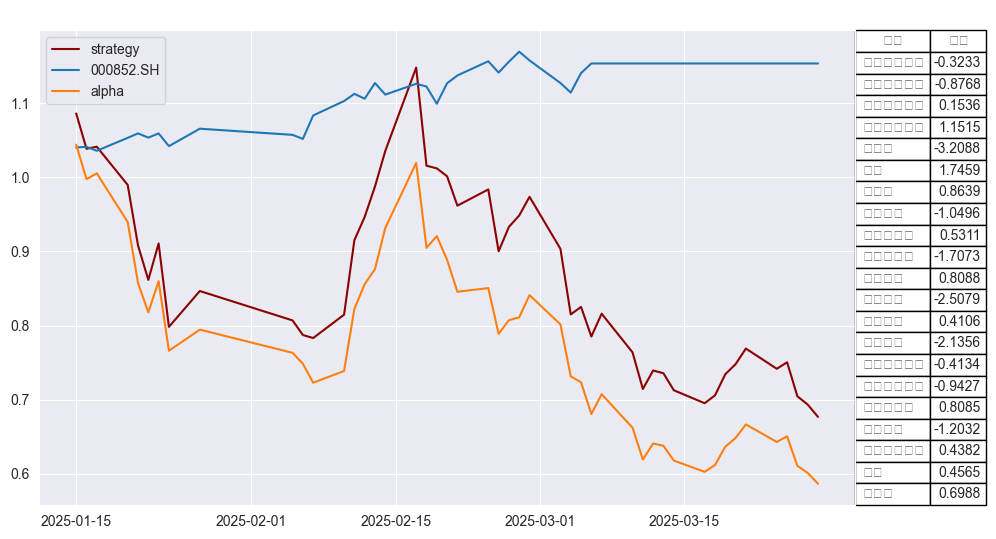

(            strategy  000852.SH    alpha
 2025-01-15  1.086138   1.040320 1.044043
 2025-01-16  1.038473   1.041064 0.997511
 2025-01-17  1.041240   1.035788 1.005263
 2025-01-20  0.989688   1.053234 0.939666
 2025-01-21  0.908141   1.059225 0.857364
 2025-01-22  0.861595   1.053570 0.817786
 2025-01-23  0.910725   1.059192 0.859831
 2025-01-24  0.798166   1.042033 0.765970
 2025-01-27  0.846533   1.065554 0.794453
 2025-02-05  0.806869   1.057273 0.763161
 2025-02-06  0.787207   1.051753 0.748471
 2025-02-07  0.783082   1.083407 0.722796
 2025-02-10  0.814564   1.102882 0.738577
 2025-02-11  0.915058   1.112642 0.822419
 2025-02-12  0.946488   1.105990 0.855784
 2025-02-13  0.987588   1.127204 0.876140
 2025-02-14  1.035498   1.111559 0.931572
 2025-02-17  1.148019   1.126174 1.019397
 2025-02-18  1.015622   1.122455 0.904823
 2025-02-19  1.012052   1.099288 0.920643
 2025-02-20  1.001364   1.126907 0.888595
 2025-02-21  0.961709   1.137396 0.845536
 2025-02-24  0.983644   1.156549 0

In [33]:
performance_cumnet,result_cn  = get_performance_analysis(account_result, name = ' ',rf = 0.03,benchmark_index = '000852.SH',benchmark_type = 'mcw')
performance_cumnet,result_cn

In [20]:
### #### 含涨跌停
df_weight = btdf_weight.copy()
change_n = 2;cash = 500000; tax = 0.0005; other_tax = 0.0001; commission = 0.0002; min_fee = 5; cash_interest_yield = 0.02; signal = False
def backtest_with_limit(df_weight, change_n = 2, cash = 10000 * 1000, tax = 0.0005, other_tax = 0.0001, commission = 0.0002, min_fee = 5, cash_interest_yield = 0.02,signal = False):
    '''
    change_n = 20: 调仓天数
    cash：资金
    tax=0.0005: 印花税
    other_tax: 0.0001其他杂费
    commission=0.0002： 券商佣金 万二
    min_fee=5: 最低交易费用
    cash_interest_yield = 0.02现金利率
    signal = False 是否打印买卖明细表
    '''

    # 基础参数
    inital_cash = cash                                # 起始资金
    stock_holding_num_hist = 0                        # 初始化持仓
    buy_cost = other_tax + commission                 # 买入交易成本
    sell_cost = tax + other_tax + commission          # 卖出交易成本
    cash_interest_daily = (1 + cash_interest_yield) ** (1/252) - 1          # 现金账户利息(日)
    ### 三个账户：总账户，股票账户，现金账户
    account = pd.DataFrame(index = df_weight.index,columns=['total_account_asset','holding_market_cap','cash_account'])          # 账户信息存储
    ### 得到 各股票一手所能买的股票数量
    stock_round_lot = pd.Series(dict([(s,200) if s.startswith('300') or s.startswith('68') else (s,100) for s in btdf_weight.columns.tolist()]))
    ### 每一天的调仓情况
    change_day = sorted(set(df_weight.index.tolist()[::change_n] + [df_weight.index[-1]]))                                        # 调仓日期
    cannot_sellable_stock_list_temp = []
    #### 取 down_limit 数据，形成同日，weight_df 所选当日股票 buy_out_stock_list_temp，所对应的 ['open','limit_down'] 两列数据
    # price_open_limit = get_price(buy_out_stock_list_temp,start_date,start_date,fields=['open','limit_down']).droplevel(1)
    # df = btdf_weight.copy()
    start_date = btdf_weight.index.min()
    end_date = btdf_weight.index.max()
    stock_list = btdf_weight.columns.tolist()
    start_date,end_date,len(stock_list)
    input_date = M.input_date(str(int(start_date)),str(int(end_date)))
    ### bug:这里时间段截取有问题：
    _,_,sel_stocks_df=M.sel_instrument_time_and_space(input_date, shift_days=1, ret_days=0, feature_type='stock', stock_board_cond=[1,2,3],
                                          stock_st_cond=0, output_df=True, is_use_cache=False)
    price_df=sel_stocks_df[sel_stocks_df.instrument.isin(stock_list)][['date','instrument','close','open','down_limit','up_limit']]##.pivot_table(index='date',columns='instrument',values='open')
    # price_df
    ### also from above price_df
    price_open = price_df.pivot_table(index='date',columns='instrument',values='open') ## 替代了 原文件中的get_bar()
    ### 逐行test，看数据输入输出和各部分作用！

    #### 含涨跌停
    # 滚动计算
    for i in tqdm(range(0,len(change_day)-1)):

        start_date = change_day[i]
        end_date = change_day[i+1]

        # 计算是否存在跌停
        if i == 0:
            pass
        else:
            buy_out_stock_list_temp = stock_holding_num_hist.index.tolist()
            # price_open_limit = get_price(buy_out_stock_list_temp,start_date,start_date,fields=['open','limit_down']).droplevel(1)
            #### 没有跌停才能卖出：
            price_open_limit = price_df[price_df['date']==start_date][['instrument','open','down_limit']].rename(columns={'down_limit':'limit_down'}).set_index('instrument')
            cannot_sellable_stock_list_temp = sorted(price_open_limit[price_open_limit['open'] == price_open_limit['limit_down']].index.tolist())
            # 若跌停，计算冻结资金
            if len(cannot_sellable_stock_list_temp) != 0: ## 即有跌停股票，奴能卖出，所以，这里要计算不能卖出的资金
                tdf=stock_holding_num_hist[stock_holding_num_hist.index.isin(cannot_sellable_stock_list_temp)]
                cannot_sellable_cash = (tdf * price_open_limit.open).dropna().sum()              # 计算冻结资金体量
                cash -= cannot_sellable_cash                                                                                                             # 刷新可用资金
                stock_holding_num_hist_cannot_sellable = stock_holding_num_hist.copy()
                for stock in cannot_sellable_stock_list_temp:
                    stock_holding_num_hist_cannot_sellable[stock] = 0       # 修改副本记录存量为0
                print(start_date,cannot_sellable_stock_list_temp,'跌停未能卖出')

        # 获取给定权重
        df_weight_temp = df_weight.loc[start_date].dropna()
        stock_list_temp = df_weight_temp.index.tolist()

        # 计算是否存在涨停
        # price_open_limit = get_price(stock_list_temp,start_date,start_date,fields=['open','limit_up']).droplevel(1)
        price_open_limit = price_df[price_df['date']==start_date][['instrument','open','up_limit']].rename(columns={'up_limit':'limit_up'}).set_index('instrument')
        stock_list_temp = sorted(price_open_limit[price_open_limit['open'] != price_open_limit['limit_up']].index.tolist())
        # 若涨停之按之前权重等比例修正买入涨停比例的股票
        sel_df_weight_df = df_weight_temp[df_weight_temp.index.isin(stock_list_temp)]
        df_weight_temp = sel_df_weight_df/sel_df_weight_df.sum()
        print('df_weight_temp:',df_weight_temp)
        # 涨停的标的输出
        cannot_buyable_stock_list_temp = sorted(price_open_limit[price_open_limit['open'] == price_open_limit['limit_up']].index.tolist())
        if len(cannot_buyable_stock_list_temp) != 0:
            print(start_date,cannot_buyable_stock_list_temp,'涨停未能买入')
        # 用剩余资金买入 计算个股持股数量 = 向下取整(给定权重 * 可用资金 // 最小买入股数) * 最小买入股数
        stock_holding_num = ((df_weight_temp
                            * cash
                            / (price_open.loc[start_date,stock_list_temp] * (1 + sell_cost))        # 预留交易费用
                            // stock_round_lot.loc[stock_list_temp])
                            * stock_round_lot.loc[stock_list_temp])

        # 仓位变动&实际持仓(上期未能卖出)
        if (i == 0) | (len(cannot_sellable_stock_list_temp) == 0):
            # 变动持仓 = 本期理论持仓 - 上期持仓
            stock_holding_num_change = stock_holding_num.sub(stock_holding_num_hist,fill_value = 0)
        else:
            # 可变动持仓 = 本期理论持仓 - 上期持仓可以卖出持仓
            stock_holding_num_change = stock_holding_num - stock_holding_num_hist_cannot_sellable
            ttdf=stock_holding_num_hist[stock_holding_num_hist.index.isin(cannot_sellable_stock_list_temp)]
            # 原有持仓 + 新
            stock_holding_num = stock_holding_num.add(ttdf,fill_value = 0)


        stock_holding_num_change = stock_holding_num_change.replace(0,np.nan).dropna()
        if signal:
            for k,v in stock_holding_num_change.to_dict().items():
                if v < 0:
                    print(start_date,'卖出',k,int(v),'股')
                else:
                    print(start_date,'买入',k,int(v),'股')


        # 获取期间价格
        price_open_temp = price_open.loc[start_date:end_date]

        # 计算交易成本 (可设置万一免五)
        def calc_fee(x,min_fee):
            if x < 0:
                fee_temp = -1 * x * sell_cost                                                                                       # 印花税 + 过户费等 + 佣金
            else:
                fee_temp = x * buy_cost                                                                                             # 过户费等 + 佣金
            # 最低交易成本限制
            if fee_temp > min_fee:
                return fee_temp
            else:
                return min_fee

        transaction_costs = ((price_open_temp.loc[start_date]
                            * stock_holding_num_change)).apply(lambda x: calc_fee(x,min_fee)).sum()
        # 计算期间市值 （交易手续费在现金账户计提）
        holding_market_cap = (price_open_temp * stock_holding_num).sum(axis =1)
        cash_account = cash - transaction_costs - holding_market_cap.loc[start_date]
        cash_account = pd.Series([cash_account*((1 + cash_interest_daily)**(i+1)) for i in range(0,len(holding_market_cap))],
                                index = holding_market_cap.index)
        total_account_asset = holding_market_cap + cash_account

        # 下一期期初可用资金
        cash = total_account_asset.loc[end_date]

        # 保存历史数据
        stock_holding_num_hist = stock_holding_num

        account.loc[start_date:end_date,'total_account_asset'] = round(total_account_asset,2)
        account.loc[start_date:end_date,'holding_market_cap'] = round(holding_market_cap,2)
        account.loc[start_date:end_date,'cash_account'] = round(cash_account,2)

    # account.loc[pd.to_datetime(get_previous_trading_date(account.index.min(),1))] = [inital_cash,0,inital_cash]
    account.loc[account.index.min()] = [inital_cash,0,inital_cash]
    account = account.sort_index()

    return account
df_weight = btdf_weight.copy()
# account
account_result = backtest_with_limit(df_weight, change_n = 1, cash = 500000, tax = 0.0005, other_tax = 0.0001, commission = 0.0002, min_fee = 5, cash_interest_yield = 0.02,signal = False)
account_result

INFO:FH_QM_DC.MQplatform:(20250113, 20250328)


查询后的,存到内存中的table df shape (216213, 115)
Loaded 216213 records into general_memory_stock_table.


 57%|█████▋    | 27/47 [00:00<00:00, 264.87it/s]

df_weight_temp: instrument
300344.SZ   0.250000
300953.SZ   0.250000
301413.SZ   0.250000
301511.SZ   0.250000
Name: 20250114.0, dtype: float64
20250114.0 ['000421.SZ', '002917.SZ', '300792.SZ'] 涨停未能买入
df_weight_temp: instrument
300344.SZ   0.333333
301413.SZ   0.333333
301511.SZ   0.333333
Name: 20250115.0, dtype: float64
20250115.0 ['000421.SZ', '002164.SZ', '002691.SZ', '002917.SZ', '300792.SZ', '600539.SH'] 涨停未能买入
df_weight_temp: instrument
000421.SZ   0.200000
300071.SZ   0.200000
300242.SZ   0.200000
300344.SZ   0.200000
300792.SZ   0.200000
Name: 20250116.0, dtype: float64
20250116.0 ['002691.SZ', '002767.SZ', '600714.SH', '603177.SH'] 涨停未能买入
df_weight_temp: instrument
300071.SZ   0.200000
300166.SZ   0.200000
300242.SZ   0.200000
300344.SZ   0.200000
300792.SZ   0.200000
Name: 20250117.0, dtype: float64
20250117.0 ['002691.SZ', '300515.SZ', '600539.SH', '600714.SH', '603177.SH'] 涨停未能买入
20250120.0 ['600243.SH'] 跌停未能卖出
df_weight_temp: instrument
002917.SZ   0.250000
600539.SH   0

100%|██████████| 47/47 [00:00<00:00, 263.17it/s]

df_weight_temp: instrument
300084.SZ   0.250000
300198.SZ   0.250000
301079.SZ   0.250000
600243.SH   0.250000
Name: 20250324.0, dtype: float64
20250324.0 ['002204.SZ', '002300.SZ', '002767.SZ', '600320.SH'] 涨停未能买入
20250325.0 ['600243.SH', '603315.SH'] 跌停未能卖出
df_weight_temp: instrument
002204.SZ   0.200000
300084.SZ   0.200000
301079.SZ   0.200000
600320.SH   0.200000
603949.SH   0.200000
Name: 20250325.0, dtype: float64
20250325.0 ['002300.SZ', '002427.SZ'] 涨停未能买入
20250326.0 ['600243.SH', '603949.SH'] 跌停未能卖出
df_weight_temp: instrument
002300.SZ   0.200000
002767.SZ   0.200000
300697.SZ   0.200000
300721.SZ   0.200000
301079.SZ   0.200000
Name: 20250326.0, dtype: float64
20250326.0 ['002427.SZ'] 涨停未能买入
df_weight_temp: instrument
002300.SZ   0.200000
300697.SZ   0.200000
300871.SZ   0.200000
300927.SZ   0.200000
300967.SZ   0.200000
Name: 20250327.0, dtype: float64
20250327.0 ['002427.SZ'] 涨停未能买入


,total_account_asset,holding_market_cap,cash_account
date,,,
20250114.000000,500000,0,500000
20250115.000000,541314.800000,538874.000000,2440.800000
20250116.000000,530889.810000,528171.000000,2718.810000
20250117.000000,532576.150000,526302.000000,6274.150000
20250120.000000,506252.730000,505072.000000,1180.730000
20250121.000000,232932.820000,436611.000000,-203678.180000
20250122.000000,97596.750000,177308.000000,-79711.250000
20250123.000000,100579.570000,86765.000000,13814.570000
20250124.000000,73254.410000,86526.000000,-13271.590000


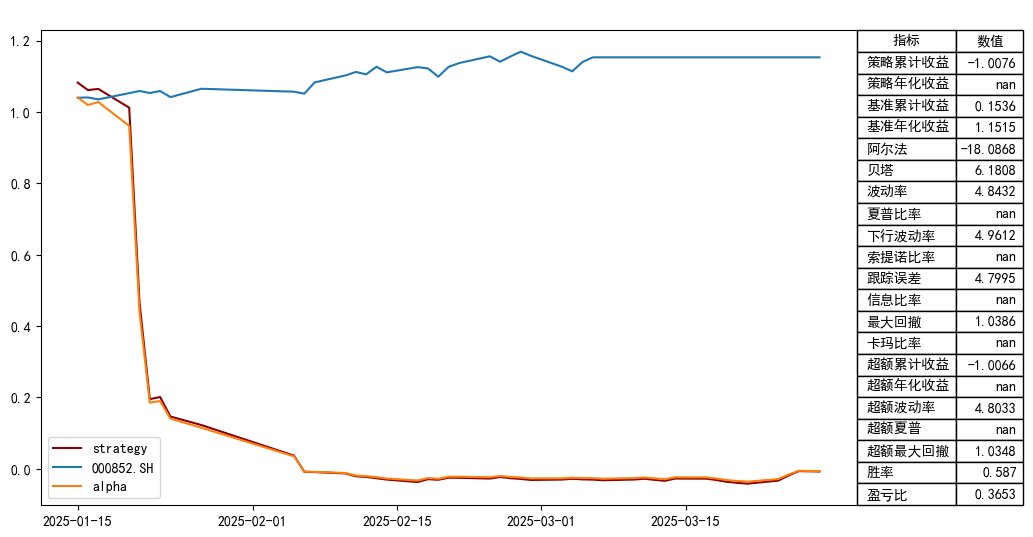

(            strategy  000852.SH     alpha
 2025-01-15  1.082630   1.040320  1.040670
 2025-01-16  1.061780   1.041064  1.019898
 2025-01-17  1.065152   1.035788  1.028350
 2025-01-20  1.012505   1.053234  0.961330
 2025-01-21  0.465866   1.059225  0.439817
 2025-01-22  0.195193   1.053570  0.185269
 2025-01-23  0.201159   1.059192  0.189918
 2025-01-24  0.146509   1.042033  0.140599
 2025-01-27  0.122614   1.065554  0.115071
 2025-02-05  0.036779   1.057273  0.034786
 2025-02-06 -0.008527   1.051753 -0.008108
 2025-02-07 -0.009387   1.083407 -0.008665
 2025-02-10 -0.013056   1.102882 -0.011838
 2025-02-11 -0.021096   1.112642 -0.018960
 2025-02-12 -0.022911   1.105990 -0.020715
 2025-02-13 -0.026565   1.127204 -0.023567
 2025-02-14 -0.030330   1.111559 -0.027286
 2025-02-17 -0.037208   1.126174 -0.033039
 2025-02-18 -0.029244   1.122455 -0.026054
 2025-02-19 -0.030863   1.099288 -0.028076
 2025-02-20 -0.025055   1.126907 -0.022233
 2025-02-21 -0.025313   1.137396 -0.022256
 2025-02-24

In [21]:
performance_cumnet,result_cn  = get_performance_analysis(account_result, name = ' ',rf = 0.03,benchmark_index = '000852.SH',benchmark_type = 'mcw')
performance_cumnet,result_cn

INFO:FH_QM_DC.MQplatform:(20250113, 20250328)


查询后的,存到内存中的table df shape (216213, 115)
Loaded 216213 records into general_memory_stock_table.


100%|██████████| 47/47 [00:00<00:00, 301.53it/s]


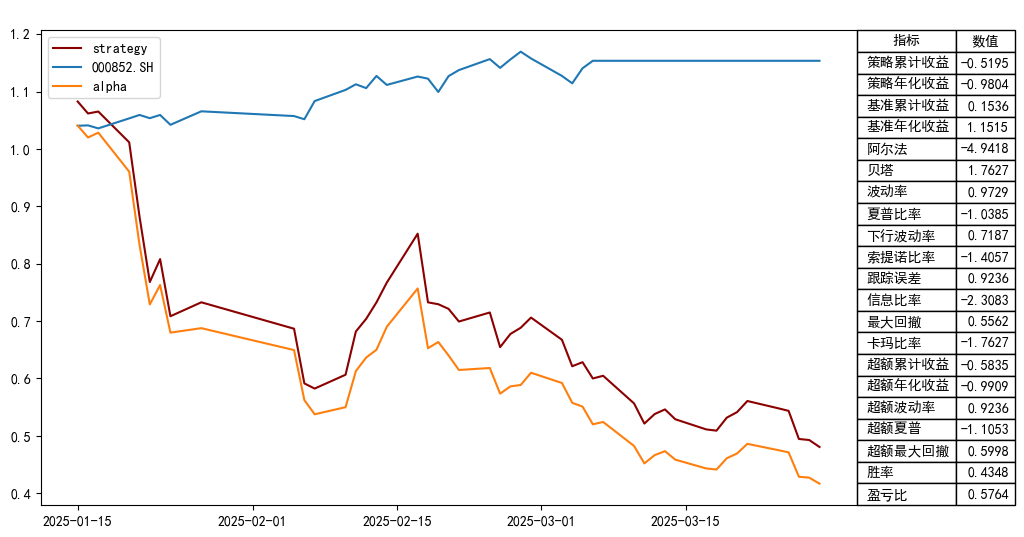

(            strategy  000852.SH    alpha
 2025-01-15  1.082630   1.040320 1.040670
 2025-01-16  1.061780   1.041064 1.019898
 2025-01-17  1.065152   1.035788 1.028350
 2025-01-20  1.011491   1.053234 0.960367
 2025-01-21  0.882265   1.059225 0.832934
 2025-01-22  0.768020   1.053570 0.728969
 2025-01-23  0.807932   1.059192 0.762781
 2025-01-24  0.708369   1.042033 0.679795
 2025-01-27  0.732654   1.065554 0.687580
 2025-02-05  0.686588   1.057273 0.649395
 2025-02-06  0.591299   1.051753 0.562203
 2025-02-07  0.582292   1.083407 0.537463
 2025-02-10  0.606423   1.102882 0.549853
 2025-02-11  0.681777   1.112642 0.612755
 2025-02-12  0.703819   1.105990 0.636370
 2025-02-13  0.732593   1.127204 0.649920
 2025-02-14  0.766915   1.111559 0.689945
 2025-02-17  0.852238   1.126174 0.756755
 2025-02-18  0.732584   1.122455 0.652663
 2025-02-19  0.729310   1.099288 0.663438
 2025-02-20  0.721191   1.126907 0.639973
 2025-02-21  0.699136   1.137396 0.614681
 2025-02-24  0.714913   1.156549 0

In [19]:
### from Claude3.7 Sonnet
def backtest_with_limit_fixed(df_weight, change_n=2, cash=10000*1000, tax=0.0005, other_tax=0.0001,
                             commission=0.0002, min_fee=5, cash_interest_yield=0.02, signal=False):

    # Basic parameters
    inital_cash = cash
    stock_holding_num_hist = pd.Series(0, index=[])  # Empty initial holdings
    buy_cost = other_tax + commission
    sell_cost = tax + other_tax + commission
    cash_interest_daily = (1 + cash_interest_yield) ** (1/252) - 1

    # Account tracking
    account = pd.DataFrame(index=df_weight.index,
                          columns=['total_account_asset', 'holding_market_cap', 'cash_account'])

    # Stock lot sizes
    stock_round_lot = pd.Series(dict([(s,200) if s.startswith('300') or s.startswith('68')
                                     else (s,100) for s in btdf_weight.columns.tolist()]))

    # Rebalance days
    change_day = sorted(set(df_weight.index.tolist()[::change_n] + [df_weight.index[-1]]))

    # Get price data
    start_date = btdf_weight.index.min()
    end_date = btdf_weight.index.max()
    stock_list = btdf_weight.columns.tolist()
    input_date = M.input_date(str(int(start_date)), str(int(end_date)))

    _, _, sel_stocks_df = M.sel_instrument_time_and_space(
        input_date, shift_days=1, ret_days=0, feature_type='stock',
        stock_board_cond=[1,2,3], stock_st_cond=0, output_df=True, is_use_cache=False)

    price_df = sel_stocks_df[sel_stocks_df.instrument.isin(stock_list)][
        ['date', 'instrument', 'close', 'open', 'down_limit', 'up_limit']]

    price_open = price_df.pivot_table(index='date', columns='instrument', values='open')

    # Rolling calculation
    for i in tqdm(range(0, len(change_day)-1)):
        start_date = change_day[i]
        end_date = change_day[i+1]

        # Check for limit down stocks that can't be sold
        cannot_sellable_stock_list_temp = []
        if i > 0 and len(stock_holding_num_hist) > 0:
            buy_out_stock_list_temp = stock_holding_num_hist.index.tolist()
            price_open_limit = price_df[price_df['date']==start_date][
                ['instrument', 'open', 'down_limit']].rename(
                columns={'down_limit':'limit_down'}).set_index('instrument')

            cannot_sellable_stock_list_temp = sorted(
                price_open_limit[price_open_limit['open'] == price_open_limit['limit_down']].index.tolist())

            if len(cannot_sellable_stock_list_temp) != 0 and signal:
                print(start_date, cannot_sellable_stock_list_temp, '跌停未能卖出')

        # Get target weights
        df_weight_temp = df_weight.loc[start_date].dropna()
        stock_list_temp = df_weight_temp.index.tolist()

        # Check for limit up stocks that can't be bought
        price_open_limit = price_df[price_df['date']==start_date][
            ['instrument', 'open', 'up_limit']].rename(
            columns={'up_limit':'limit_up'}).set_index('instrument')

        # Filter out stocks that are limit up
        available_stocks = sorted(price_open_limit[
            price_open_limit['open'] != price_open_limit['limit_up']].index.tolist())

        # Adjust weights for available stocks
        sel_df_weight_df = df_weight_temp[df_weight_temp.index.isin(available_stocks)]
        if len(sel_df_weight_df) > 0:
            df_weight_temp = sel_df_weight_df/sel_df_weight_df.sum()

        cannot_buyable_stock_list_temp = sorted(price_open_limit[
            price_open_limit['open'] == price_open_limit['limit_up']].index.tolist())

        if len(cannot_buyable_stock_list_temp) != 0 and signal:
            print(start_date, cannot_buyable_stock_list_temp, '涨停未能买入')

        # Create a modified version of holdings that excludes stocks that can't be sold
        stock_holding_num_sellable = stock_holding_num_hist.copy()
        for stock in cannot_sellable_stock_list_temp:
            if stock in stock_holding_num_sellable:
                stock_holding_num_sellable[stock] = 0

        # Calculate target holdings based on available cash
        stock_list_temp = df_weight_temp.index.tolist()
        stock_holding_num = pd.Series(0, index=stock_list_temp)

        if len(stock_list_temp) > 0:
            stock_holding_num = ((df_weight_temp
                                * cash
                                / (price_open.loc[start_date, stock_list_temp] * (1 + sell_cost))
                                // stock_round_lot.loc[stock_list_temp])
                                * stock_round_lot.loc[stock_list_temp])

        # Calculate position changes
        stock_holding_num_change = stock_holding_num.sub(stock_holding_num_sellable, fill_value=0)
        stock_holding_num_change = stock_holding_num_change.replace(0, np.nan).dropna()

        # Add back stocks that couldn't be sold
        for stock in cannot_sellable_stock_list_temp:
            if stock in stock_holding_num_hist:
                if stock not in stock_holding_num:
                    stock_holding_num[stock] = stock_holding_num_hist[stock]
                else:
                    stock_holding_num[stock] += stock_holding_num_hist[stock]

        if signal:

            for k,v in stock_holding_num_change.to_dict().items():
                if v < 0:
                    print(start_date,'卖出',k,int(v),'股')
                else:
                    print(start_date,'买入',k,int(v),'股')


        # 获取期间价格
        price_open_temp = price_open.loc[start_date:end_date]

        # 计算交易成本 (可设置万一免五)
        def calc_fee(x,min_fee):
            if x < 0:
                fee_temp = -1 * x * sell_cost                                                                                       # 印花税 + 过户费等 + 佣金
            else:
                fee_temp = x * buy_cost                                                                                             # 过户费等 + 佣金
            # 最低交易成本限制
            if fee_temp > min_fee:
                return fee_temp
            else:
                return min_fee

        transaction_costs = ((price_open_temp.loc[start_date]
                            * stock_holding_num_change)).apply(lambda x: calc_fee(x,min_fee)).sum()
        # 计算期间市值 （交易手续费在现金账户计提）
        holding_market_cap = (price_open_temp * stock_holding_num).sum(axis =1)
        cash_account = cash - transaction_costs - holding_market_cap.loc[start_date]
        cash_account = pd.Series([cash_account*((1 + cash_interest_daily)**(i+1)) for i in range(0,len(holding_market_cap))],
                                index = holding_market_cap.index)
        total_account_asset = holding_market_cap + cash_account

        # 下一期期初可用资金
        cash = total_account_asset.loc[end_date]

        # 保存历史数据
        stock_holding_num_hist = stock_holding_num

        account.loc[start_date:end_date,'total_account_asset'] = round(total_account_asset,2)
        account.loc[start_date:end_date,'holding_market_cap'] = round(holding_market_cap,2)
        account.loc[start_date:end_date,'cash_account'] = round(cash_account,2)

    # account.loc[pd.to_datetime(get_previous_trading_date(account.index.min(),1))] = [inital_cash,0,inital_cash]
    account.loc[account.index.min()] = [inital_cash,0,inital_cash]
    account = account.sort_index()

    return account
df_weight = btdf_weight.copy()
# account
account_result = backtest_with_limit_fixed(df_weight, change_n = 1, cash = 500000, tax = 0.0005, other_tax = 0.0001, commission = 0.0002, min_fee = 5, cash_interest_yield = 0.02,signal = False)
account_result
performance_cumnet,result_cn  = get_performance_analysis(account_result, name = ' ',rf = 0.03,benchmark_index = '000852.SH',benchmark_type = 'mcw')
performance_cumnet,result_cn

In [28]:
#### from DeepSeek R1 code
### #### 含涨跌停
### #### 含涨跌停
df_weight = btdf_weight.copy()
change_n = 1;cash = 500000; tax = 0.0005; other_tax = 0.0001; commission = 0.0002; min_fee = 5; cash_interest_yield = 0.02; signal = False
# def backtest_with_limit_dsr1(df_weight, change_n=2, cash=10000*1000, tax=0.0005,
#                        other_tax=0.0001, commission=0.0002, min_fee=5,
#                        cash_interest_yield=0.02, signal=False):
'''
修正后的含涨跌停回测函数
'''
# 基础参数
inital_cash = cash
stock_holding_num_hist = pd.Series(dtype=float)  # 使用Series存储持仓
buy_cost = other_tax + commission
sell_cost = tax + other_tax + commission
cash_interest_daily = (1 + cash_interest_yield) ** (1/252) - 1

account = pd.DataFrame(index=df_weight.index,
                      columns=['total_account_asset','holding_market_cap','cash_account'])

# 获取股票基本信息
stock_round_lot = pd.Series(
    {s: 200 if s.startswith(('300','68')) else 100
     for s in df_weight.columns},
    name='round_lot'
)

# 获取价格数据
start_date = df_weight.index.min()
end_date = df_weight.index.max()
stock_list = df_weight.columns.tolist()

# 获取完整的行情数据
_, _, sel_stocks_df = M.sel_instrument_time_and_space(
    M.input_date(str(int(start_date)), str(int(end_date))),
    shift_days=1,
    ret_days=0,
    feature_type='stock',
    stock_board_cond=[1,2,3],
    stock_st_cond=0,
    output_df=True,
    is_use_cache=False
)
price_df = sel_stocks_df[sel_stocks_df.instrument.isin(stock_list)][
    ['date','instrument','open','down_limit','up_limit']
]
price_open = price_df.pivot_table(index='date', columns='instrument', values='open')
price_open = price_open.reindex(df_weight.index).ffill()  # 对齐日期索引


# # 新增日期对齐逻辑
# valid_dates = price_open.index.intersection(df_weight.index)
# df_weight = df_weight.loc[valid_dates]
# price_open = price_open.loc[valid_dates]
#
# # 修改change_days生成逻辑
# change_days = sorted(set(valid_dates[::change_n].tolist() + [valid_dates[-1]]))
#
# # 在循环开始处添加日期验证
# for i in tqdm(range(len(change_days)-1)):
#     curr_date = change_days[i]
#     next_date = change_days[i+1]
#
#     # 新增日期存在性检查
#     if curr_date not in price_open.index:
#         print(f"Warning: {curr_date} not in price data, skipping")
#         continue



# 主回测循环
change_days = sorted(set(df_weight.index.tolist()[::change_n] + [df_weight.index[-1]]))

for i in tqdm(range(len(change_days)-1)):
    curr_date = change_days[i]
    next_date = change_days[i+1]

    # ========== 处理卖出（前一日持仓） ==========
    # 检查跌停无法卖出的股票
    if not stock_holding_num_hist.empty:
        curr_limit_down = price_df[price_df.date == curr_date].set_index('instrument')
        limit_down_mask = (curr_limit_down['open'] <= curr_limit_down['down_limit'])
        cannot_sell_stocks = limit_down_mask[limit_down_mask].index.tolist()

        # 分离可卖出和不可卖出持仓
        sellable_holdings = stock_holding_num_hist.drop(cannot_sell_stocks, errors='ignore')
        frozen_holdings = stock_holding_num_hist.loc[cannot_sell_stocks].copy()
    else:
        sellable_holdings = pd.Series(dtype=float)
        frozen_holdings = pd.Series(dtype=float)

    # ========== 处理买入（当日信号） ==========
    # 获取目标权重
    target_weights = df_weight.loc[curr_date].dropna()

    # 排除涨停股票
    curr_limit_up = price_df[price_df.date == curr_date].set_index('instrument')
    limit_up_mask = (curr_limit_up['open'] >= curr_limit_up['up_limit'])
    cannot_buy_stocks = limit_up_mask[limit_up_mask].index.tolist()
    valid_weights = target_weights.drop(cannot_buy_stocks, errors='ignore')

    # 重新标准化权重
    if valid_weights.sum() > 0:
        valid_weights /= valid_weights.sum()
    else:
        valid_weights = pd.Series(dtype=float)  # 当日无有效标的

    # ========== 计算目标持仓 ==========
    # 可用资金 = 现金 + 可卖出持仓市值
    sellable_value = (sellable_holdings * price_open.loc[curr_date]).sum()
    available_cash = cash + sellable_value

    # 计算目标持仓
    target_values = valid_weights * available_cash
    target_shares = (target_values / (price_open.loc[curr_date] * (1 + buy_cost))
                    // stock_round_lot) * stock_round_lot

    # ========== 执行交易 ==========
    # 计算交易变化
    shares_change = target_shares.sub(stock_holding_num_hist, fill_value=0)

    # 计算交易费用
    trade_values = shares_change.abs() * price_open.loc[curr_date]
    fees = trade_values.where(shares_change < 0, trade_values * buy_cost)  # 卖出费用含税
    fees = fees.where(fees >= min_fee, min_fee)
    total_fees = fees.sum()

    # 更新现金账户
    cash = available_cash - target_shares.dot(price_open.loc[curr_date]) - total_fees

    # ========== 更新持仓 ==========
    # 合并保留的冻结持仓和新持仓
    new_holdings = target_shares.add(frozen_holdings, fill_value=0)
    new_holdings = new_holdings[new_holdings > 0].dropna()  # 去除零持仓

    # ========== 更新账户信息 ==========
    ### 此处应该是
    date_range = M.input_date(curr_date, next_date)[2] ##pd.date_range(curr_date, next_date)
    holding_values = (price_open.loc[date_range] * new_holdings).sum(axis=1)
    cash_growth = cash * (1 + cash_interest_daily) ** np.arange(len(date_range))

    account.loc[date_range, 'total_account_asset'] = holding_values.values + cash_growth
    account.loc[date_range, 'holding_market_cap'] = holding_values.values
    account.loc[date_range, 'cash_account'] = cash_growth

    # 更新循环变量
    stock_holding_num_hist = new_holdings.copy()
    cash = cash_growth[-1]  # 期末现金转入下一期

# 填充初始值
account.iloc[0] = [inital_cash, 0, inital_cash]
# return account
account_result = account
# # 执行回测
# df_weight = btdf_weight.copy()
# account_result = backtest_with_limit_dsr1(
#     df_weight,
#     change_n=1,
#     cash=500000,
#     tax=0.0005,
#     other_tax=0.0001,
#     commission=0.0002,
#     min_fee=5,
#     cash_interest_yield=0.02,
#     signal=False
# )
# account_result
# performance_cumnet,result_cn  = get_performance_analysis(account_result, name = ' ',rf = 0.03,benchmark_index = '000852.SH',benchmark_type = 'mcw')
# performance_cumnet,result_cn

INFO:FH_QM_DC.MQplatform:(20250113, 20250328)


查询后的,存到内存中的table df shape (216213, 115)
Loaded 216213 records into general_memory_stock_table.


100%|██████████| 47/47 [00:00<00:00, 180.82it/s]


In [27]:
account_result

,total_account_asset,holding_market_cap,cash_account
date,,,
20250114.000000,500000,0,500000
20250115.000000,NaN,0.000000,NaN
20250116.000000,NaN,0.000000,NaN
20250117.000000,NaN,0.000000,NaN
20250120.000000,NaN,0.000000,NaN
20250121.000000,NaN,0.000000,NaN
20250122.000000,NaN,0.000000,NaN
20250123.000000,NaN,0.000000,NaN
20250124.000000,NaN,0.000000,NaN


In [22]:
curr_date = 20250114
next_date = 20250115
M.input_date(curr_date, next_date)[2]

[20250114, 20250115]

In [20]:
date_range = M.input_date(curr_date, next_date)[2]
date_range

NameError: name 'curr_date' is not defined

### 草稿

In [25]:
curr_date = '2025-01-14'
next_date = '2025-01-15'
date_range = pd.date_range(curr_date, next_date)
date_range

DatetimeIndex(['2025-01-14', '2025-01-15'], dtype='datetime64[ns]', freq='D')

In [69]:
tdf=stock_holding_num_hist[stock_holding_num_hist.index.isin(cannot_sellable_stock_list_temp)]
tdf

instrument
000856.SZ   116100.000000
000882.SZ   351200.000000
603211.SH    60100.000000
605277.SH             NaN
dtype: float64

In [73]:
(tdf * price_open_limit.open).dropna()#.sum()

instrument
000856.SZ   1330506.000000
000882.SZ   1067648.000000
603211.SH   1159930.000000
dtype: float64

In [53]:
price_open_limit[price_open_limit['open'] == price_open_limit['limit_down']]['instrument'].values.tolist()

['600243.SH']

In [47]:
cannot_sellable_stock_list_temp

[24985]

In [21]:
df_weight_temp

instrument
000421.SZ   0.200000
300344.SZ   0.200000
300953.SZ   0.200000
301413.SZ   0.200000
301511.SZ   0.200000
Name: 20250114.0, dtype: float64

In [ ]:
#这里是自定义的一个参数，用来定义买几支股票
stock_count = G.params['stock_count']
# 这里获取需要操作的当天的股票数据
prediction_data = G.prediction_data[G.prediction_data['date'] == now]
# 这里按照factor1=return_5列进行降序排列
prediction_data = prediction_data.sort_values(by=['factor1'], ascending=False).reset_index(drop=True)
# 然后获取前stock_count的股票进行操作
stocks = prediction_data['instrument'].head(stock_count)
# 可能不一定实际有stock_count支票，所以这里获取下实际的个数，用来计算资金分配
real_stock_count = len(stocks)
# 总资产
total_cash = G.total_assets
# 可用资金
available_cash = G.available_cash
# 这里是自定义的计算可以用来世界买的可用资金，用户可以设定自己的逻辑
available_cash = available_cash if available_cash < total_cash / 2 else total_cash / 2
#G.trade_engine.order_value(stock,hold_num)此方法用于买入卖出股票。
#stock：股票代码，hold_num：股票数量，大于等于0的整数
#若未持仓，则是买入hold_num手
#若已持仓，则会将持仓数量变为hold_num。(hold_num>持仓，则补仓，即买入；反正即卖出；为0则是平仓)
# 买入股票
for stock_name in stocks:
    temp_cash = available_cash / real_stock_count
    G.trade_engine.order_value(stock_name, temp_cash)
# 由于设定的第一天买，第二天卖，所以这里会卖出持有的票。具体持仓几天可以自己去定义逻辑。
# 卖出持仓股票  G.position为当前持仓
for _p in G.positions:
    if G.positions[_p].hold_num > 0:
        G.trade_engine.order_target(_p, 0)
# # 交易模块
# trade_result = M.ct_trader(
#     name='test_strategy',
#     # 初始资金50W，持仓5支票
#     params={"cash": 500000, "stock_count": 5},
#     trade_date_block=trade_date_block.get_data(),
#     trade_prediction_data=trade_data_result.get_data(),
#     executeFunc=test_trade_execute)

